---
title: 3.4 模型选择、欠拟合和过拟合
date: 2024-2-5 14:00:00
tags: [机器学习,pytorch]
categories: [机器学习]
comment: true
toc: true
---
#
<!--more-->
# 4 模型选择、欠拟合和过拟合
- 将模型在训练数据上拟合的比在潜在分布中更接近的现象称为过拟合（overfitting），用于对抗过拟合的技术称为正则化（regularization）。
- 如果有足够多的神经元、层数和训练迭代周期，模型最终可以在训练集上达到完美的精度，此时测试集的准确性却下降了。
## 4.1 训练误差和泛化误差
- 训练误差（training error）：模型在训练数据集上计算得到的误差。
- 泛化误差（generalization error）：模型应用在同样从原始样本的分布中抽取的无限多数据样本时，模型误差的期望。
### 4.1.1 统计学习理论
- 假设训练数据和测试数据都是从相同的分布中独立提取的。这通常被称为独立同分布假设。（这意味着对数据进行采样的过程没有进行“记忆”。换句话说，抽取的第2个样本和第3个样本的相关性，并不比抽取的第2个样本和第200万个样本的相关性更强。）

### 4.1.2 模型复杂性
- 一个模型是否能很好地泛化取决于很多因素。例如，具有更多参数的模型可能被认为更复杂，参数有更大取值范围的模型可能更为复杂。通常对于神经网络，我们认为需要更多训练迭代的模型比较复杂，而需要早停（earlystopping）的模型（即较少训练迭代周期）就不那么复杂。
- 几个影响模型泛化的因素：
    - 可调整参数的数量。当可调整参数的数量（有时称为自由度）很大时，模型往往更容易过拟合。
    - 参数采用的值。当权重的取值范围较大时，模型可能更容易过拟合。
    - 训练样本的数量。即使模型很简单，也很容易过拟合只包含一两个样本的数据集。而过拟合一个有数百万个样本的数据集则需要一个极其灵活的模型。
## 4.2 验证集
- 为了确定候选模型中的最佳模型，我们通常会使用验证集。
- 在我们确定所有的超参数之前，我们不希望用到测试集。如果我们在模型选择过程中使用测试数据，可能会有过拟合测试数据的风险。我们也不能仅仅依靠训练数据来选择模型，因为我们无法估计训练数据的泛化误差。
- 验证数据和测试数据的边界模糊，我写的代码中使用的测试集严格来说是验证集。

### 4.2.1 K折交叉验证
- 当训练数据稀缺时，我们甚至可能无法提供足够的数据来构成一个合适的验证集
- 原始训练数据被分成K个不重叠的子集。然后执行K次模型训练和验证，每次在K − 1个子集上进行训练，并在剩余的一个子集（在该轮中没有用于训练的子集）上进行验证。最后，通过对K次实验的结果取平均来估计训练和验证误差。

## 4.3 欠拟合与过拟合
- 欠拟合：训练误差和验证误差都很大，但有一点差距。说明模型表达能力不足，需要更复杂的模型。
- 过拟合：训练误差和验证误差之间的差距很大。最终关心的是验证误差。
- 是否过拟合或欠拟合可能取决于模型复杂性和可用训练数据集的大小。

### 4.3.1 模型复杂性
![](4img/1.png)
![](img/deeplearning/code/pytorch/3_mlp/4img/1.png)

### 4.3.2 数据集大小
- 模型复杂性和数据集大小之间通常存在关系。如果没有足够的数据，简单的模型可能更有用。\

## 4.4 多项式回归
- 为了更好地理解模型选择、欠拟合和过拟合，我们可以通过多项式回归来考虑这些问题。



In [7]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"
import math
import numpy as np
import torch
from torch import nn
from d2l import torch as d2l

### 4.4.1 生成数据集
- $$y= 5+1.2x-\frac{x^2}{2!}+5.6\frac{x^3}{3!}+\epsilon， \quad \epsilon \sim N(0,0.1^2)$$

In [8]:
#1 生成100个样本
max_degree= 20 #多项式的最大阶数, 用更多的阶数表示更复杂的模型为了演示过拟合，正常用四项就可，仅用两项欠拟合，用20项过拟合
n_train, n_test= 100,100 #训练集、测试集大小
true_w= np.zeros(max_degree) #分配大量的空间(20,)
true_w[0:4]= np.array([5, 1.2, -3.4, 5.6])#w前4项赋值
features= np.random.normal(size=(n_train+n_test,1)) #（200,1）
np.random.shuffle(features)
poly_features= np.power(features,np.arange(max_degree).reshape(1,-1)) #一个feature扩展成20项：0次方到19次方（200,20）
for i in range(max_degree):
    poly_features[:,i]/=math.gamma(i+1) #gamma(n)=(n-1)! #一个feature的每一项都除以i的阶乘
labels= np.dot(poly_features,true_w) #（200,20）*（20,）=（200,）
labels += np.random.normal(scale=0.1,size=labels.shape) #加上噪声

#NumPy ndarray -> tensor
true_w, features, poly_features, labels= [torch.tensor(x, dtype=torch.float32) for x in [true_w, features, poly_features, labels]]
print(features[:2], poly_features[:2,:], labels[:2],sep='\n') #两个x, 两个20项后的x，两个y

tensor([[ 0.3571],
        [-1.5272]])
tensor([[ 1.0000e+00,  3.5710e-01,  6.3759e-02,  7.5893e-03,  6.7753e-04,
          4.8388e-05,  2.8799e-06,  1.4691e-07,  6.5578e-09,  2.6019e-10,
          9.2914e-12,  3.0163e-13,  8.9759e-15,  2.4656e-16,  6.2889e-18,
          1.4972e-19,  3.3414e-21,  7.0189e-23,  1.3925e-24,  2.6170e-26],
        [ 1.0000e+00, -1.5272e+00,  1.1661e+00, -5.9360e-01,  2.2663e-01,
         -6.9220e-02,  1.7618e-02, -3.8437e-03,  7.3374e-04, -1.2450e-04,
          1.9014e-05, -2.6397e-06,  3.3594e-07, -3.9464e-08,  4.3048e-09,
         -4.3827e-10,  4.1832e-11, -3.7579e-12,  3.1882e-13, -2.5626e-14]])
tensor([ 5.0956, -4.0147])


### 4.4.2 训练与测试


In [9]:
#2 评估损失
def evaluate_loss(net, data_iter, loss): #@save
    """评估给定数据集上模型的损失"""
    metric= d2l.Accumulator(2) #损失总和，样本数量
    for X,y in data_iter:
        out= net(X)
        y= y.reshape(out.shape)
        l= loss(out,y)
        metric.add(l.sum(),l.numel())
    return metric[0]/metric[1] #平均损失

#3 训练
def train(train_features, test_features, train_labels, test_labels, num_epochs=400):
    loss= nn.MSELoss(reduction='none')
    input_shape= train_features.shape[-1]
    net= nn.Sequential(nn.Linear(input_shape,1,bias=False))
    batch_size= min(10, train_labels.shape[0])
    train_iter= d2l.load_array((train_features, train_labels.reshape(-1,1)), batch_size)
    test_iter= d2l.load_array((test_features, test_labels.reshape(-1,1)), batch_size, is_train=False)
    trainer= torch.optim.SGD(net.parameters(), lr=0.01)
    animator= d2l.Animator(xlabel='epoch', ylabel='loss', yscale='log', xlim=[1, num_epochs], ylim=[1e-3, 1e2], legend=['train','test'])
    for epoch in range(num_epochs):
        d2l.train_epoch_ch3(net, train_iter, loss, trainer)
        if epoch==0 or (epoch+1)%20==0:
            animator.add(epoch+1, (evaluate_loss(net, train_iter, loss),evaluate_loss(net, test_iter, loss)))
    print('weight:', net[0].weight.data.numpy())

### 4.4.3 三阶多项式函数拟合（正常）


weight: [[ 4.98059    1.1953405 -3.389903   5.607252 ]]


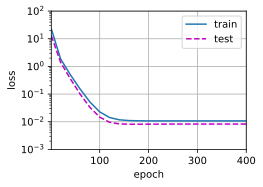

In [10]:
# 从多项式特征中选择前4个维度：1，x，x^2，x^3
train(poly_features[:n_train,:4], poly_features[n_train:, :4], labels[:n_train], labels[n_train:])

### 4.4.4 线性函数拟合（欠拟合）


weight: [[2.9687963 4.1943007]]


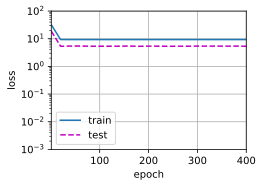

In [11]:
# 从多项式特征中选择前2个维度：1，x
train(poly_features[:n_train,:2], poly_features[n_train:, :2], labels[:n_train], labels[n_train:])

### 4.4.5 高阶多项式函数拟合（过拟合）

weight: [[ 4.96578789e+00  1.30018699e+00 -3.35006833e+00  5.17666531e+00
  -1.19773000e-01  9.30291474e-01 -9.37245637e-02 -2.67241318e-02
   1.06728293e-01 -1.89072818e-01 -1.45296961e-01 -1.12053894e-01
   1.03521936e-01 -3.26722339e-02  1.13504946e-01  3.62291411e-02
  -4.04332444e-04  3.25103179e-02 -7.38418847e-02 -1.19887017e-01]]


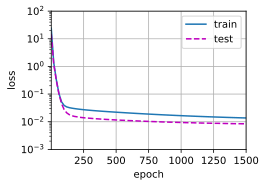

In [12]:
train(poly_features[:n_train, :], poly_features[n_train:, :], labels[:n_train], labels[n_train:], num_epochs=1500)